In [28]:
import torch
import torch.nn.functional as F

import torchio as tio
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np


In [29]:
data_path = Path('/mnt/arbeit/simon/repo/myKeymorph/data3d/images-resampled')
image_paths = sorted(data_path.glob('*.nii'))[:1]
print(image_paths)
subjects = []
for image_path in image_paths:
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        labels=tio.LabelMap(image_path.__str__().replace('images-resampled', 'labels-resampled')))
    subjects.append(subject)
transform = tio.Compose([
            tio.ToCanonical(), 
            tio.ZNormalization(masking_method=tio.ZNormalization.mean)
        ])
subset = tio.SubjectsDataset(subjects,transform)
loader = torch.utils.data.DataLoader(subset,1)

# flip = [-1]
# flip = [-2]
# flip = [-3]
# flip = [-1,-2]
# flip = [-1,-3]
# flip = [-2,-3]
# flip = [-1,-2,-3]

for img in loader:
    img_data = img['mri'][tio.DATA].float().transpose(-1,-3).flip([-1,-3])
    labels_data = img['labels'][tio.DATA].float().transpose(-1,-3).flip([-1,-3])
print([img_data.shape])


[PosixPath('/mnt/arbeit/simon/repo/myKeymorph/data3d/images-resampled/AFIDS_0000.nii')]
[torch.Size([1, 1, 128, 128, 128])]


In [30]:
import sys
sys.path.append("/mnt/arbeit/simon/repo/myKeymorph/")
import source
import importlib
importlib.reload(source)
from source import transforms

tensor([[[ 0.9812,  0.0664, -0.0264, -0.2454],
         [-0.0379,  1.0782,  0.0482,  0.1164],
         [-0.0364, -0.0226,  0.9335, -0.0306],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])
tensor([ 0.0156, -0.1406, -0.1875])
tensor([-0.2345, -0.0449, -0.2030])


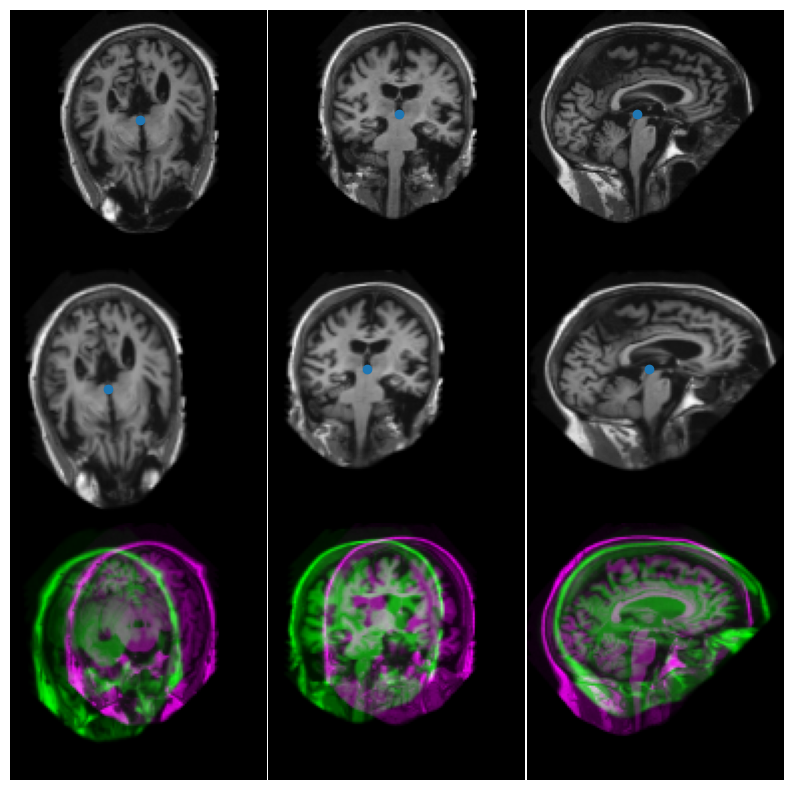

In [35]:
n_batch = labels_data.shape[0]
kp_coords = torch.zeros((n_batch, 32, 3), dtype=torch.float32)

for i,kp_label in enumerate(range(1,33)):
    b,c,z,y,x= torch.where(labels_data == kp_label)
    kp_coords[b, i, 0] = x.float()
    kp_coords[b, i, 1] = y.float()
    kp_coords[b, i, 2] = z.float()

kp_coords = (kp_coords - (img_data.shape[-1]/2)) / (img_data.shape[-1]/2)

def get_img_slice(img_data, b_idx, slice_idx, axis):
    return torch.index_select(img_data[b_idx,:,:,:,:].squeeze(), axis, slice_idx).squeeze().numpy()

def make_img_kp_plot(img_data, kp_coords, b_idx, kp_idx, axes):
    other_idx = [(2,0,1), (1,0,2), (0,1,2)]
    for i,ax in enumerate(axes):
        slice_idx = torch.round(kp_coords[b_idx,kp_idx,other_idx[i][0]] * (img_data.shape[-1]/2) + (img_data.shape[-1]/2)).int()
        img_slice = get_img_slice(img_data, b_idx, slice_idx, i)
        ax.imshow(img_slice, cmap='gray', origin='upper', extent=(-1,1,1,-1), aspect='equal')
        ax.scatter(kp_coords[b_idx,kp_idx,other_idx[i][1]], kp_coords[b_idx,kp_idx,other_idx[i][2]])

def make_img_img_plot(img_data1, img_data2, b_idx, axes):
    slice_idx = torch.Tensor([64]).int()
    for i,ax in enumerate(axes):
        stack = []
        for img_data in [img_data1, img_data2]:
            img_slice = get_img_slice(img_data, b_idx, slice_idx, i)
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
            stack.append(img_slice)
        stack.append(stack[0])
        ax.imshow(np.stack(stack, axis=-1), origin='upper', extent=(-1,1,1,-1), aspect='equal')

def make_img(img_data1,kp_coords1,img_data2,kp_coords2,b_idx,kp_idx):
    fig, axes = plt.subplots(3,3, figsize=(10,10))
    make_img_kp_plot(img_data1, kp_coords1, b_idx, kp_idx, axes[0,:])
    make_img_kp_plot(img_data2, kp_coords2, b_idx, kp_idx, axes[1,:])
    make_img_img_plot(img_data1, img_data2, b_idx, axes[2,:])
    for ax in axes.flatten():
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)



params = {'max_scale':0.1, 'max_translation':0.3, 'max_rotation':0, 'max_shear':0.1}
test_transform = transforms.AffineTransform3D()
test_transform.randomize_matrix(**params) 

transformed_img = test_transform.apply_to_img(img_data)
transformed_kp = test_transform.apply_to_kp(kp_coords)

b_idx = 0
kp_idx = 1

print(test_transform.matrix)
print(kp_coords[b_idx,kp_idx,:])
print(transformed_kp[b_idx,kp_idx,:])

make_img(img_data, kp_coords, transformed_img, transformed_kp, b_idx, kp_idx)

